# Traffic signs detection

# setup

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt    # for plotting histogram and image
import os    # image and annotation file paths
from pathlib import Path     # file paths
from skimage.exposure import is_low_contrast
import pandas as pd      # dataframe to store the metadata
import gradio as gr     # simple application
from time import time    # compute the computational time
import random

D:\UTAR course\UCCC2513 mini project\traffic_signs_det_proj\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Display random images

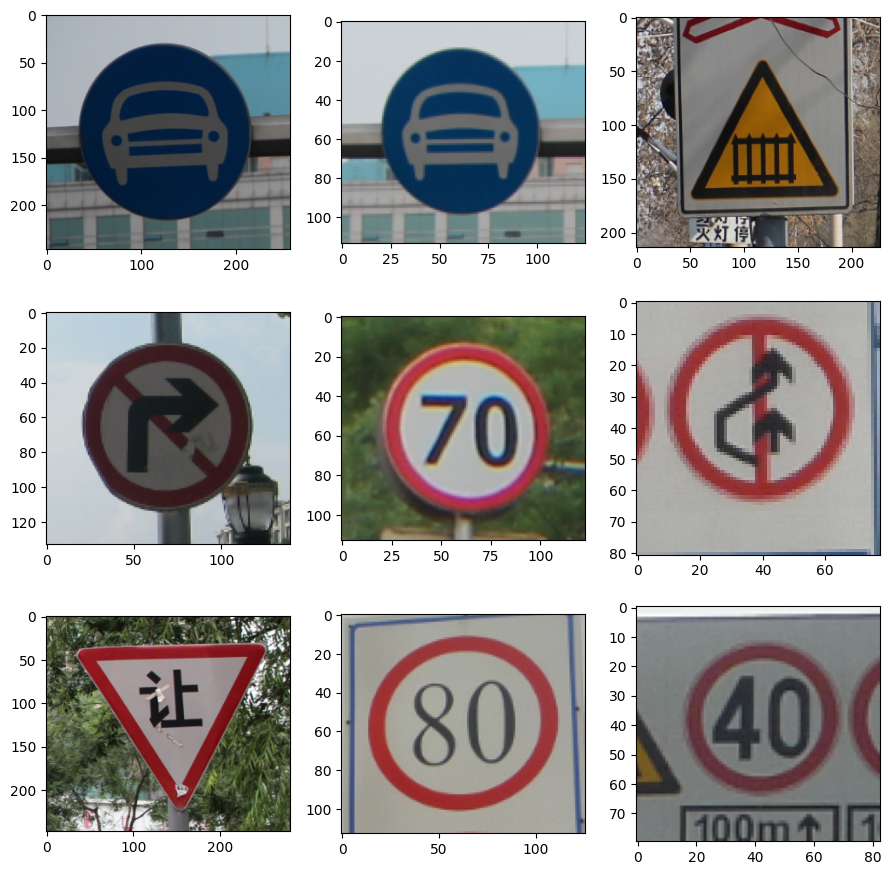

In [2]:
image_dir = "data/train_data/"   # 4170 images

list_img_paths = os.listdir(image_dir)
random.Random(0).shuffle(list_img_paths)

plt.figure(figsize=(9, 9))
for i, filename in enumerate(list_img_paths[:9]):
    img = cv.imread(image_dir + filename)
    plt.subplot(3, 3, i+1)
    if img is not None:
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.imshow(img_rgb)

plt.tight_layout()
plt.show()

Some important observations:
1. The images are cropped to have just a single traffic sign in the centre.
2. The images are of different sizes.

# Visualize the dataset annotations (metadata)

In [3]:
df_metadata = pd.read_csv("data/TsignRecgTrain4170Annotation.txt", sep=";", header=None, index_col=0)
df_metadata.sample(3)

,1,2,3,4,5,6,7,8
0,,,,,,,,
005_0026_j.png,124,113,27,28,89,90,5,NaN
001_1_0010.png,80,81,17,16,70,71,1,NaN
028_1_0108.png,146,149,25,26,122,126,28,NaN


<!-- <div style="background: linear-gradient(45deg, #f0f0f0, #e0e0e0); 
            color: black; 
            padding: 20px; 
            border-radius: 10px; 
            box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); 
            font-family: Arial, sans-serif; 
            max-width: 400px; 
            margin: 20px auto;">
<p> -->
1. Remove the last column <br>
2. Change index and header names
<!-- </p>
</div> -->

In [5]:
# sanity checking
img = cv.imread("data/train_data/028_1_0108.png")
img.shape

(149, 146, 3)

We know the first column is the *image width* while second column is the *image height*.

In [6]:
df_metadata.index.names = ["filenames"]

In [7]:
# remove last column and rename headers
df_metadata.drop([8], axis=1, inplace=True)
df_metadata.columns = ["width", "height", "x1", "y1", "x2", "y2", "categories"]
df_metadata.head(3)

,width,height,x1,y1,x2,y2,categories
filenames,,,,,,,
000_0001.png,134,128,19,7,120,117,0
000_0002.png,165,151,23,12,149,138,0
000_0003.png,128,122,22,14,116,105,0


In [8]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4170 entries, 000_0001.png to 056_1_0054.png
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   width       4170 non-null   int64
 1   height      4170 non-null   int64
 2   x1          4170 non-null   int64
 3   y1          4170 non-null   int64
 4   x2          4170 non-null   int64
 5   y2          4170 non-null   int64
 6   categories  4170 non-null   int64
dtypes: int64(7)
memory usage: 260.6+ KB


There is no missing values in the metadata! 🙂

# Main processes (functions) to construct the project workflow

In [9]:
def preprocess_image(img, denoise_method, fixed_width=200):
    """
    Preprocessing steps:
    1. Resizing by preserving the aspect ratio
    2. Denoising, depending on user choices
    3. Enhance contrast given low contrast
    4. Convert the color space

    Arguments:
    ---
    1. img: input image (ndarray)
    2. denoise_method: median or Gaussian blur (string)
    3. fixed_width: 200 (default, int)

    Returns:
    ---
    1. preprocessed image (ndarray: 3-channel uint8)
    2. preprocessed grayscale image (ndarray: 1-channel uint8)
    3. scaling factor (float)
    """
    # resizing
    ratio = fixed_width / img.shape[1]
    resized = cv.resize(img, None, fx=ratio, fy=ratio, interpolation=cv.INTER_AREA)

    # Denoise 
    if denoise_method == "Gaussian":
        denoised = cv.GaussianBlur(resized, (5, 5), 0)
    elif denoise_method == "median":
        denoised = cv.medianBlur(resized, 5)
    else:
        raise Exception("Wrong input argument of denoising methods. Choose either Gaussian and median")

    # enhance contrast
    if is_low_contrast(denoised):
        denoised = contrast_enhance(denoised)

    # convert to grayscale
    gray = cv.cvtColor(denoised, cv.COLOR_BGR2GRAY)

    return denoised, gray, ratio

In [10]:
def contrast_enhance(img):
    """
    Contrast enhancement technique:
    1. change from BGR to LAB color space
    2. split the channels: L, A and B channels
    3. apply histogram equalization on L
    4. Merge the color channels back into LAB
    5. convert from LAB to BGR

    Arguments:
    ---
    img: color image (uint8 3-channel array)

    Returns:
    ---
    Contrast enhanced image (8-bit 3 channel NumPy array)
    """
    if len(img.shape) == 3:
        img_lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
        l, a, b = cv.split(img_lab)
        l_eq = cv.equalizeHist(l)
        eq = cv.merge((l_eq, a, b))
        return cv.cvtColor(eq, cv.COLOR_LAB2BGR)
    else:
        raise Exception("Input must be color images")

# Edge detection functions
1. Zero-parameter Canny edge detector
2. Gabor filter
3. Structured forest edge detection.

## Canny edge detection
The zero-parameter Canny edge detection has been written in `utils.py`.

## Gabor filter

In [11]:
# Gabor filter implementation
def get_gabor_filters(num_filters, ksize=25, sigma=7, lambda_=7, gamma=0.5, psi=0):
    """
    Create a list Gabor filters.
    Args:
    ---
    num_filters: number of filters (int)
    ksize: kernel size, high value means more contextual info but more computationally expensive (int)
    sigma: standard deviation of Gaussian envelope. Low value attenuates fine details. (float)
    lambda_: low values lead to high-frequency filter and vice versa (float)
    gamma: aspect ratio of Gaussian envelope. (float)
    psi: phase offset (symmetrical: 0 and np.pi)

    Returns:
    ---
    List of gabor filters
    """
    filters = []

    for theta in np.arange(0, np.pi, np.pi / num_filters):
        kernel = cv.getGaborKernel((ksize, ksize), sigma, theta, lambda_, gamma, psi, ktype=cv.CV_32F)
        kernel /= kernel.sum()
        filters.append(kernel)

    return filters

def apply_Gabor_filter(img, filters):
    """
    Apply Gabor filter on grayscale images on different orientations.

    Arguments:
    ---
    img: grayscale image (np.array)
    filters: list of Gabor filters (different thetas)

    Returns:
    ---
    resulting image (np.uint8 image)
    """
    output_image = np.empty_like(img)

    for kernel in filters:
        img_filter = cv.filter2D(img, -1, kernel)
        np.maximum(output_image, img_filter, output_image)

    # normalize to [0-255]
    output_image = cv.normalize(output_image, None, 255, 0, cv.NORM_MINMAX)
    # otsu thresholding
    # return output_image
    return cv.threshold(output_image, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

In [12]:
from utils import display_images

In [13]:
img = cv.imread("data/train_data/000_0001.png", 0)
gb_filters = get_gabor_filters(4)
res = apply_Gabor_filter(img, gb_filters)
display_images([img, res], ("grayscale", "gabor filter"))

## Structured forest edge detection

In [14]:
# structured forest
model_path = "structured_forest_model/model.yml"
edge_detector = cv.ximgproc.createStructuredEdgeDetection(model_path)

def structured_forest_edge(img, edge_detector=edge_detector):
    """Structured forest edge detection
    1. convert input to RGB
    2. Normalize to [0-1]
    3. Structured forest edge detection

    Args:
    ---
    img: BGR image (numpy array)
    edge_detector: model file path (str)

    Returns:
    ---
    resulting edge map (8-bit 1 channel)
    """
    # convert to rgb
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_norm = img_rgb.astype(np.float32) / 255
    # edge_detector = cv.ximgproc.createStructuredEdgeDetection(trained_model_path)
    edges = edge_detector.detectEdges(img_norm)
    orientation = edge_detector.computeOrientation(edges)
    edges = edge_detector.edgesNms(edges, orientation)
    return np.where(edges > 0.2, 255, 0).astype(np.uint8)

In [15]:
img = cv.imread("data/train_data/000_0001.png")
res = structured_forest_edge(img)

display_images([img, res], ("image", "results"))

In [16]:
arr = np.array([0, 12, 52, 64])
res = cv.normalize(arr, None, 255, 0, cv.NORM_MINMAX)
res

array([[  0],
       [ 48],
       [207],
       [255]], dtype=int32)

## Color based segmentation

In [17]:
# define HSV color range for red, blue, yellow and black
lower_bounds = [
    (0, 40, 60),   # red
    (165, 40, 60),   # red
    (90, 40, 60),   # blue
    (20, 40, 60),   # yellow
    (0, 0, 0)      # black
]

# match with lower bounds
upper_bounds = [
    (10, 255, 225),
    (179, 255, 225),
    (120, 255, 225),
    (35, 255, 225),
    (179, 255, 10)
]

def color_seg(img, kernel_size=None):
    """Color based segmentation for blue, red, yellow and black
    1. Convert to HSV
    2. Perform segmentation on each color and combine the mask with OR operator
    3. perform morphological operation on the resulting mask
    Arguments:
    ---
    img: Input image (uint8 NumPy array)
    kernel_size: kernel size of morphological operation (structuring element, int)

    Returns:
    ---
    combined binary mask (8-bit 1 channel)
    """
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # initialize zeros array like input image
    mask_combined = np.zeros(img.shape[:2], dtype=np.uint8)

    for lower, upper in zip(lower_bounds, upper_bounds):
        mask = cv.inRange(img_hsv, lower, upper)
        mask_combined |= mask

    # morphological opening and closing
    if kernel_size is not None:
        struc_elem = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    else:
        struc_elem = np.ones((3, 3), dtype=np.uint8)

    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_OPEN, struc_elem)
    mask_combined = cv.morphologyEx(mask_combined, cv.MORPH_CLOSE, struc_elem)
    return mask_combined

## Shape detection
1. Rectangle detection
2. Circle detection
3. Combine results in (1) and (2).

In [18]:
def detect_rect(cnts, coef=0.1):
    """Return the largest rectangle (contours)
    Arguments:
    ---
    cnts: A list of contours
    coef: Determine the approximation accuracy in contour simplification, default: 0.1.

    Returns:
    ---
    Contour corresponding to the largest contour
    """
    rect_list = []
    for cnt in cnts:
        perimeter = cv.arcLength(cnt, True)
        approx = cv.approxPolyDP(cnt, coef * perimeter, True)
        if len(approx) == 4:
            rect_list.append(cnt)
    return max(rect_list, key=lambda c: cv.contourArea(c)) if rect_list else np.array([])

In [19]:
# Hough circle transform
# define the parameters
hct_params = {
    "dp": 1.5,
    "minDist": 150,
    "param1": 200,
    "param2": 15,
    "minRadius": 10,
    "maxRadius": 100
}

def detect_circle(img, params):
    """Detect circle with Hough Circle transform
    Arguments:
    img: 8-bit single-channel image in which circles are to be detected.
    hough_dict: Hough circle transform parameters (dict)

    Returns:
    numpy.ndarray or None: The largest circle contour if found, otherwise None.
    """
    mask_circle = np.zeros_like(img)
    circles = cv.HoughCircles(
        img,
        cv.HOUGH_GRADIENT,
        dp=hct_params["dp"],
        minDist=hct_params["minDist"],
        param1=hct_params["param1"],
        param2=hct_params["param2"],
        minRadius=hct_params["minRadius"],
        maxRadius=hct_params["maxRadius"]
    )
    if circles is not None:
        largest_circle = max(circles[0], key=lambda x: x[2])
        x_center, y_center, radius = largest_circle
        cv.circle(mask_circle, (int(x_center), int(y_center)), int(radius), 255, -1)
        cnt_circle, _ = cv.findContours(mask_circle, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        return cnt_circle[0]
    else:
        return np.array([])

In [20]:
# integrate the rectangle and circle detection results
def combine_cnts(cnt1, cnt2, cnt=None):
    """
    Combines and selects the most significant contour from detected rectangles, circles,
    and any additional contours based on their areas.

    Args:
    cnt1: Contour detected.
    cnt2: Contour detected.
    cnt: List of additional contours detected in the image.

    Returns:
    numpy.ndarray: The most significant contour (either rectangle, circle, or another contour)
                   based on the largest area. Returns an empty array if no contours are found.
    """
    if (cnt1.size > 0) and (cnt2.size > 0):
        if cv.contourArea(cnt1) > cv.contourArea(cnt2):
            return cnt1
        else:
            return cnt2

    elif (cnt1.size > 0) and (cnt2.size == 0):
        return cnt1

    elif (cnt2.size > 0) and (cnt1.size == 0):
        return cnt2

    else:
        if cnt:
            return max(cnt, key=cv.contourArea)
        else:
            return np.array([])

In [21]:
def detect_obj(edges, mask, route):
    """perform edge detection and color segmentation
    Arguments:
    ---
    edges: Output from edge detection.
    mask: output from color-based segmentation
    route: either "edges" or "color".

    Return:
    ---
    A single contour.
    """
    # edges
    if route == "edges":
        cnts, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        rect_largest = detect_rect(cnts)
        circle_largest = detect_circle(edges, hct_params)
        return combine_cnts(rect_largest, circle_largest, cnts)

    # color segmentation
    if route == "color":
        cnts, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        rect_largest = detect_rect(cnts)
        circle_largest = detect_circle(mask, hct_params)
        return combine_cnts(rect_largest, circle_largest, cnts)

# IOU and Dice computation 
This has been coded in `utils.py`.

In [26]:
from utils import computeIOUandDice, auto_canny, display_image

## Experiment with one image (debugging purpose)

In [27]:
img = cv.imread("data/train_data/000_0002.png")
#1: preprocess image
denoised, gray, scale_factor = preprocess_image(img, denoise_method="Gaussian")
display_images([img, denoised], ("original", "preprocess")) # debug

#2a: edge detection
edge = auto_canny(gray, method="median")
display_image("edge", edge)

#2b: color segmentation
color_mask = color_seg(denoised)
display_image("color", color_mask)

#3a: contour detection from edge: we get the contour surrounding object of interest
edge_res = detect_obj(edge, None, route="edges")
img_copy = denoised.copy()
cv.drawContours(img_copy, [edge_res], -1, (0, 255, 0), 2)
display_image("edge", img_copy)

#3b: contour detection from color segmentation: 
color_seg_res = detect_obj(None, color_mask, route="color")
img_copy = denoised.copy()
cv.drawContours(img_copy, [color_seg_res], -1, (255, 0, 0), 2)
display_image("color seg", img_copy)

#4: combine
final_cnt = combine_cnts(edge_res, color_seg_res)
img_copy = denoised.copy()
cv.drawContours(img_copy, [color_seg_res], -1, (0, 0, 255), 2)
display_image("final contour", img_copy)

# bounding box 
x, y, w, h = cv.boundingRect(final_cnt)
img_copy = denoised.copy()
cv.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 1)
display_image("bb", img_copy)
# ground truth bounding box
x1, y1, x2, y2 = df_metadata.loc["000_0002.png"]["x1"], df_metadata.loc["000_0002.png"]["y1"], \
                 df_metadata.loc["000_0002.png"]["x2"], df_metadata.loc["000_0002.png"]["y2"]
x1, y1, x2, y2 = x1 * scale_factor, y1 * scale_factor, x2 * scale_factor, y2 * scale_factor
cv.rectangle(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 1)
display_image("bb", img_copy)
#5: compute IOU and Dice
pred = (int(x), int(y), int(x + w), int(y + h))
gt = (int(x1), int(y1), int(x2), int(y2))
IOU, Dice = computeIOUandDice(pred, gt)

cv.putText(img_copy, f"IOU:{IOU:.2f}, Dice: {Dice:.2f}", (10, 20), 
          cv.FONT_HERSHEY_SIMPLEX, 0.3, (100, 50, 150))
display_image("IOUDice", img_copy)

# Run through all the images
1. Gaussian filtering + Canny edge detection
2. Gaussian filtering + Gabor filter
3. Gaussian filtering + Structured forest edge detection
4. Median filtering + Canny edge detection
5. Median filtering + Gabor filter
6. Median filtering + Structured forest edge detection

> * Modify the input argument of `preprocess_image()` on line **19**
> * Modify the edge detection methods by uncommenting / commenting some codes on lines 25-30.

In [28]:
IOUs = []
Dices = []
times_exe = []
imgFile_zero_det = []
imgFile_zero_IOU = []

img_dir = Path() / "data" / "train_data"
i = 0

for file in img_dir.glob("*.png"):
    str_fn = str(file)
    i += 1
    start_time = time()
    img = cv.imread(str_fn)
    if img is None:
        print(f"{str_fn} does not exist.")
        continue

    #1: preprocess image
    denoised, gray, scale_factor = preprocess_image(img, denoise_method="median")
    # display_images([img, denoised], ("original", "preprocess")) # debug
    
    #2a: edge detection
    # Canny
    # edge = auto_canny(gray, method="median")
    # Gabor filter
    # gb_filters = get_gabor_filters(4)
    # edge = apply_Gabor_filter(gray, gb_filters)
    # structured forest detection
    edge = structured_forest_edge(denoised)
    # display_image("edge", edge)
    
    #2b: color segmentation
    color_mask = color_seg(denoised)
    # display_image("color", color_mask)
    
    #3a: contour detection from edge: we get the contour surrounding object of interest
    edge_res = detect_obj(edge, None, route="edges")
    # img_copy = img.copy()
    # cv.drawContours(img_copy, [edge_res], -1, (0, 255, 0), 2)
    # display_image("edge", img_copy)
    
    #3b: contour detection from color segmentation: 
    color_seg_res = detect_obj(None, color_mask, route="color")
    # img_copy = img.copy()
    # cv.drawContours(img_copy, [color_seg_res], -1, (255, 0, 0), 2)
    # display_image("color seg", img_copy)
    
    #4: combine
    final_cnt = combine_cnts(edge_res, color_seg_res)
    if final_cnt is not None:
        # img_copy = denoised.copy()
        # cv.drawContours(img_copy, [final_cnt], -1, (0, 0, 255), 2)
        # display_image("final contour", img_copy)
        x, y, w, h = cv.boundingRect(final_cnt)
        img_file_as_index = str_fn.split("\\")[-1]
        x1, y1, x2, y2 = df_metadata.loc[img_file_as_index]["x1"], df_metadata.loc[img_file_as_index]["y1"], \
                         df_metadata.loc[img_file_as_index]["x2"], df_metadata.loc[img_file_as_index]["y2"]
        x1, y1, x2, y2 = x1 * scale_factor, y1 * scale_factor, x2 * scale_factor, y2 * scale_factor
        pred = (int(x), int(y), int(x + w), int(y + h))
        gt = (int(x1), int(y1), int(x2), int(y2))
        IOU, Dice = computeIOUandDice(pred, gt)
        IOUs.append(IOU)
        Dices.append(Dice)
        # To find certain images with low or zero IOU
        if IOU == 0:
            imgFile_zero_IOU.append(str_fn)
    else:
        IOUs.append(0)
        Dices.append(0)
        img_zero_det.append(str_fn)

    times_exe.append(time() - start_time)
    # visualization
    if final_cnt is not None:
        if (i % 1000 == 0) or (i == 1):
            img_copy = denoised.copy()
            cv.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 1)
            cv.rectangle(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 1)
            display_image("bb", img_copy)
            # print(x, y, x+w, y+h)
            # print(x1, y1, x2, y2)

## Performances
### Gaussian + auto canny

In [80]:
print(len(IOUs), len(Dices), len(times_exe))

4170 4170 4170


In [81]:
perf_dict = {
    "IOU_gauss_canny": IOUs,
    "Dice_gauss_canny": Dices,
    "times_gauss_canny": times_exe
}
df1 = pd.DataFrame(perf_dict)
df1.head()

,IOU_gauss_canny,Dice_gauss_canny,times_gauss_canny
0,0.962919,0.981109,0.015671
1,0.744538,0.853564,0.063033
2,0.698206,0.822287,0.015632
3,0.814508,0.897773,0.031676
4,0.880993,0.936732,0.046900


In [82]:
df1.describe()

,IOU_gauss_canny,Dice_gauss_canny,times_gauss_canny
count,4170.000000,4170.000000,4170.000000
mean,0.775326,0.857355,0.022399
std,0.197346,0.146429,0.011050
min,0.000000,0.000000,0.000000
25%,0.638672,0.779499,0.015625
50%,0.855899,0.922355,0.016035
75%,0.940958,0.969581,0.031253
max,1.000000,1.000000,0.094918


### Median + auto canny

In [85]:
perf_dict = {
    "IOU_median_canny": IOUs,
    "Dice_median_canny": Dices,
    "times_median_canny": times_exe
}
df1 = pd.DataFrame(perf_dict)
df1.head()

,IOU_median_canny,Dice_median_canny,times_median_canny
0,0.911011,0.953433,0.019444
1,0.912439,0.954215,0.036729
2,0.715343,0.834053,0.030813
3,0.909129,0.952402,0.016136
4,0.832095,0.908354,0.029663


In [86]:
df1.describe()

,IOU_median_canny,Dice_median_canny,times_median_canny
count,4170.000000,4170.000000,4170.000000
mean,0.777321,0.857926,0.024238
std,0.201492,0.149520,0.008351
min,0.098202,0.178841,0.000000
25%,0.634431,0.776332,0.018017
50%,0.868029,0.929353,0.023260
75%,0.942458,0.970377,0.029336
max,1.000000,1.000000,0.092364


### Gaussian + Gabor filter

In [93]:
perf_dict = {
    "IOU_Gaussian_Gabor": IOUs,
    "Dice_Gaussian_Gabor": Dices,
    "times_Gaussian_Gabor": times_exe
}
df1 = pd.DataFrame(perf_dict)
df1.head()

,IOU_Gaussian_Gabor,Dice_Gaussian_Gabor,times_Gaussian_Gabor
0,0.962919,0.981109,0.047177
1,0.744538,0.853564,0.054675
2,0.698206,0.822287,0.041550
3,0.711681,0.831558,0.042805
4,0.778618,0.875531,0.034376


In [94]:
df1.describe()

,IOU_Gaussian_Gabor,Dice_Gaussian_Gabor,times_Gaussian_Gabor
count,4170.000000,4170.000000,4170.000000
mean,0.700085,0.806140,0.036169
std,0.198565,0.150956,0.015658
min,0.040517,0.077878,0.005526
25%,0.556862,0.715365,0.028349
50%,0.708367,0.829292,0.034130
75%,0.880021,0.936182,0.042199
max,1.000000,1.000000,0.438971


### Median + Gabor filter

In [90]:
perf_dict = {
    "IOU_median_Gabor": IOUs,
    "Dice_median_Gabor": Dices,
    "times_median_Gabor": times_exe
}
df1 = pd.DataFrame(perf_dict)
df1.head()

,IOU_median_Gabor,Dice_median_Gabor,times_median_Gabor
0,0.911011,0.953433,0.038226
1,0.912439,0.954215,0.052397
2,0.715343,0.834053,0.043506
3,0.909129,0.952402,0.031831
4,0.830203,0.907225,0.035894


In [91]:
df1.describe()

,IOU_median_Gabor,Dice_median_Gabor,times_median_Gabor
count,4170.000000,4170.000000,4170.000000
mean,0.707794,0.810312,0.036670
std,0.204761,0.156654,0.012882
min,0.059469,0.112261,0.005536
25%,0.557284,0.715713,0.028972
50%,0.736187,0.848051,0.035316
75%,0.891575,0.942680,0.042358
max,1.000000,1.000000,0.244047


### Gaussian + structured forest edge detection

In [99]:
perf_dict = {
    "IOU_Gaussian_sf": IOUs,
    "Dice_Gaussian_sf": Dices,
    "times_Gaussian_sf": times_exe
}
df1 = pd.DataFrame(perf_dict)
df1.head()

,IOU_Gaussian_sf,Dice_Gaussian_sf,times_Gaussian_sf
0,0.962919,0.981109,0.044330
1,0.744538,0.853564,0.053130
2,0.698206,0.822287,0.037873
3,0.814508,0.897773,0.031855
4,0.880993,0.936732,0.053142


In [100]:
df1.describe()

,IOU_Gaussian_sf,Dice_Gaussian_sf,times_Gaussian_sf
count,4170.000000,4170.000000,4170.000000
mean,0.795029,0.871123,0.035897
std,0.191212,0.139149,0.010622
min,0.126550,0.224669,0.013225
25%,0.654286,0.791019,0.031755
50%,0.882489,0.937577,0.034306
75%,0.947544,0.973065,0.039733
max,1.000000,1.000000,0.340214


### Median + structured forest edge detection

In [29]:
perf_dict = {
    "IOU_median_sf": IOUs,
    "Dice_median_sf": Dices,
    "times_median_sf": times_exe
}
df1 = pd.DataFrame(perf_dict)
df1.head()

,IOU_median_sf,Dice_median_sf,times_median_sf
0,0.911011,0.953433,0.078146
1,0.912439,0.954215,0.078423
2,0.715343,0.834053,0.062492
3,0.909129,0.952402,0.062495
4,0.799557,0.888615,0.046879


In [30]:
df1.describe()

,IOU_median_sf,Dice_median_sf,times_median_sf
count,4170.000000,4170.000000,4170.000000
mean,0.802538,0.876324,0.053185
std,0.188488,0.136330,0.012473
min,0.090676,0.166274,0.031230
25%,0.667043,0.800271,0.046874
50%,0.890075,0.941841,0.046877
75%,0.948583,0.973613,0.062499
max,1.000000,1.000000,0.250871


In [38]:
print(len(imgFile_zero_IOU))

0


In [40]:
(np.array(IOUs) == 0).any()

np.False_

#### Histogram of IOU and Dice coefficient

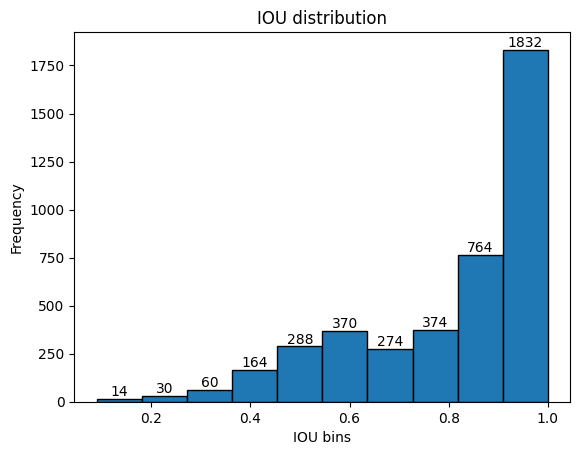

In [44]:
counts, bins, patches = plt.hist(IOUs, bins=10, edgecolor="black")

plt.xlabel("IOU bins")
plt.ylabel("Frequency")

for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, f"{int(height)}",
            ha="center", va="bottom")

plt.grid(False)
plt.title("IOU distribution")
plt.show()

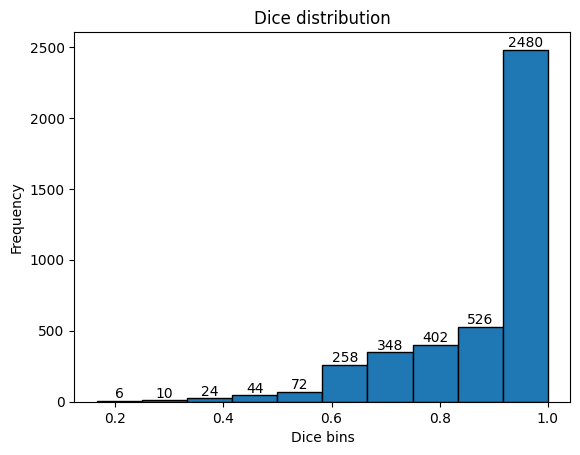

In [45]:
counts, bins, patches = plt.hist(Dices, bins=10, edgecolor="black")

plt.xlabel("Dice bins")
plt.ylabel("Frequency")

for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, f"{int(height)}",
            ha="center", va="bottom")

plt.grid(False)
plt.title("Dice distribution")
plt.show()

## Web application with Gradio

In [41]:
def detect_traffic_sign(img_path, denoise_method, edge_detector):
    """Function that works at the back end of Gradio interface
    Arguments:
    ---
    img_path:
    denoise_method:
    edge_detector:
    """
    start_time = time()
    img = cv.imread(img_path)

    if denoise_method == "Gaussian blur":
        resized, gray, scale_factor = preprocess_image(img, denoise_method="Gaussian")
    elif denoise_method == "Median blur":
        resized, gray, scale_factor = preprocess_image(img, denoise_method="median")

    img_copy = img.copy()

    if edge_detector == "Canny edge":
        edge = auto_canny(resized, method="median")
    elif edge_detector == "Gabor filters":
        gb_filters = get_gabor_filters(4)
        edge = apply_Gabor_filter(gray, gb_filters)
    elif edge_detector == "Structured forest":
        model_path = "structured_forest_model/model.yml"
        edge_detector = cv.ximgproc.createStructuredEdgeDetection(model_path)
        edge = structured_forest_edge(resized, edge_detector=edge_detector)

    color_mask = color_seg(denoised)

    edge_res = detect_obj(edge, None, route="edges")
    color_seg_res = detect_obj(None, color_mask, route="color")
    final_cnt = combine_cnts(edge_res, color_seg_res)
    
    if final_cnt.size > 0:
        x, y, w, h = cv.boundingRect(final_cnt)
        coords_bb = np.array([x, y, x + w, y + h]) / scale_factor
        coords_bb = np.int_(coords_bb)
        cv.rectangle(img_copy, (coords_bb[0], coords_bb[1]), (coords_bb[2], coords_bb[3]), (0, 255, 0), 1)
        text = "traffic sign detected!"

    else:
        text = "No traffic sign detected!"
        
    img_copy = cv.cvtColor(img_copy, cv.COLOR_BGR2RGB)
    time_det = "{:.3f}".format(time() - start_time)
    return img_copy, time_det, text

In [42]:
interface_traffic_sign_det = gr.Interface(
    fn=detect_traffic_sign,
    inputs=[
        gr.Image(type="filepath"),
        gr.Radio(["Gaussian blur", "Median blur"], label="Denoising Methods"),
        gr.Radio(["Canny edge", "Gabor filters", "Structured forest"], label="Edge detection")
    ],
    outputs=[
        gr.Image(type="numpy", label="Output image"),
        gr.Textbox(label="Execution time"),
        gr.Textbox(label="status")
    ],
    title="Simple traffic sign detection app",
    description="Traffic sign detection: select the denoising and edge detection methods.",
    allow_flagging="never"
)

interface_traffic_sign_det.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
